In [175]:
#Imports
import random as random
import copy as copy
import plotly.express as px
import pandas as pd  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from copy import deepcopy
from statistics import mean
from scipy import stats

MAX_DEPTH = 5
MIN_DEPTH = 2
POPULATION_SIZE = 60

#DEFINE FUNCTIONS
def mult(x, y): return x*y
def add(x, y):  return x+y
def sub(x, y):  return x-y
#def div(x, y):  return x/y

FUNCTIONS = [mult, add, sub]
OPS = ['*', '+', '-']
OPERANDS = ['x', -2, -1, 0, 1, 2]

#f(x) => optimal solution.
def optimal(x):
    return x*x*x + 3*x + 10

#Data used to calculate Mean Absolute Error.
def dataset():
    dataset = []
    for x in range(-100, 101, 2):        
        dataset.append([x/100, optimal(x/100)])
    return dataset

#CLASS EXPRESSION TREE
class ExpressionTree():

    #initalise
    def __init__(self, value = None, left = None, right = None):
        self.value = value
        self.left = left
        self.right = right
        
    #returns size of the tree
    def size(self, left = 0, right = 0): 

        #traverse subtrees and count
        if (self.left): 
            left = self.left.size()
        if (self.right): 
            right = self.right.size() 
            
        return 1 + left + right

    #Creates a random subtree
    def generate_tree(self, grow, max_depth, depth = 0): 
        
        #Tree still needs to become larger, add a operator
        if (depth < MIN_DEPTH or (depth < max_depth and grow is False)): 
            self.value = FUNCTIONS[random.randint(0, len(FUNCTIONS)-1)]

        #Tree has reached max size 
        elif (depth >= max_depth):   
            self.value = OPERANDS[random.randint(0, len(OPERANDS)-1)]
        
        else: 
            if (random.random() > 0.5): 
                self.value = OPERANDS[random.randint(0, len(OPERANDS)-1)]
            else:
                self.value = FUNCTIONS[random.randint(0, len(FUNCTIONS)-1)]
        
        #If value is an operator
        if (self.value in FUNCTIONS):
            self.left = ExpressionTree()          
            self.left.generate_tree(grow, max_depth, depth = depth + 1)            
            
            self.right = ExpressionTree()
            self.right.generate_tree(grow, max_depth, depth = depth + 1)
    
    #calculates expressions f(x) 
    def evaluate_tree(self, x): 
        
        #if value is an operator 
        if (self.value in FUNCTIONS): 
            return self.value(self.left.evaluate_tree(x), self.right.evaluate_tree(x))
        elif self.value == 'x': 
            return x
        else: 
            return self.value
    
    #Builds new expression tree
    def build_subtree(self):
        
        #Intialise new expression tree
        subtree = ExpressionTree()
        subtree.value = self.value
        
        if self.left:
            subtree.left = self.left.build_subtree()
        if self.right:
            subtree.right = self.right.build_subtree()
        return subtree
    
    #return sub tree
    def get_subtree(self, nodes, second):
        nodes[0] -= 1
        if (nodes[0] <= 1):
            return self.build_subtree()
        else:  
            returnVal = None              
            if (self.left and nodes[0] > 1): 
                returnVal = self.left.get_subtree(nodes, second)  
            if (self.right and nodes[0] > 1): 
                returnVal = self.right.get_subtree(nodes, second)  
            return returnVal

    #glue subtree into tree
    def glue_subtree(self, nodes, second):
        nodes[0] -= 1
        if (nodes[0] <= 1):
            self.value  = second.value
            self.left  = second.left
            self.right = second.right
        else:  
            returnVal = None              
            if (self.left and nodes[0] > 1): 
                returnVal = self.left.glue_subtree(nodes, second)  
            if (self.right and nodes[0] > 1): 
                returnVal = self.right.glue_subtree(nodes, second)  
                return returnVal

    def crossover(self, parent2): # crossover 2 trees at random nodes
        if (random.random() < 0.8):
            #get random subtree from other parent.
            subtree = parent2.get_subtree([random.randint(1, parent2.size())], None)
            
            #add subtree from parent1 into parent 2.
            self.glue_subtree([random.randint(1, self.size())], subtree)
    
    #Mutation acts on every node in the subtree
    def mutation(self):
        #if mutation probability => mutate else traverse to next node in tree.
        if (random.random() < 0.15):
            self.generate_tree(grow = True, max_depth = 2)
        elif self.left: 
            self.left.mutation()
        elif self.right: 
            self.right.mutation() 
            
    #LOCAL SEARCH (Adds 0.1 to nodes in old tree, then checks if the updated tree is better)
    def local_search_one(self, head, dataset):

        old_tree = copy.deepcopy(head)

        if(self.value not in FUNCTIONS and self.value != "x"):
            self.value += 0.1
            #if the trees fitness is better
            if(individual_fitness(head, dataset) > individual_fitness(old_tree, dataset)):
                #Revert value back to original
                self.value -= 0.1
            
            return

        #Traverse
        if(self.left):  
            self.left.local_search_one(old_tree, dataset)
        if(self.right): 
            self.right.local_search_one(old_tree, dataset)


#INITIALISE POPULATION
def initalise_population(): 
    population = []
    
    for max_d in range(3, MAX_DEPTH + 1):

        for i in range(int(POPULATION_SIZE/6)):
            rand_tree = ExpressionTree()
            rand_tree.generate_tree(grow = True, max_depth = max_d)
            population.append(rand_tree) 
            
        for i in range(int(POPULATION_SIZE/6)):
            rand_tree = ExpressionTree()
            rand_tree.generate_tree(grow = False, max_depth = max_d)
            population.append(rand_tree) 

    return population
    
#TRAVERSE TREE BY IN ORDER FASHION
def inorder(node):
        
    if(node.left): inorder(node.left)
    if(node.value in FUNCTIONS):
        print(node.value.__name__)
    else:
        print(node.value)
    if(node.right): inorder(node.right)

In [176]:
#LOCAL SEARCH TECHNIQUE

In [7]:
#When a tree is print in an in order fashion it is valid when
# 1. The first node is 'x' or a number
# 2. After the first output each node is an operator followed by operand followed by operator......
# 3. Last node is 'x' or a number
# Example: [x, +, 5, *, 2, -0, *, 6]
#.          0. 1. 2. 3. 4.  5. 6. 7
def validate_helper(tree):
    treeElements = []
    validate_tree(tree, treeElements)
    operators = ['add', 'sub', 'mult']
    
    for i in range(0, (len(treeElements) - 1)):
        if (i % 2 == 0):
            if(treeElements[i] in operators):
                return False
        
        else:
            if(treeElements[i] not in operators):
                return False
    
    if (treeElements[0] in FUNCTIONS):
        return False
    
    return True
                
def validate_tree(node, treeElements):
    
    if(node.left): validate_tree(node.left, treeElements)
        
    if(node.value in FUNCTIONS):
        treeElements.append(str(node.value.__name__))
    else:
         treeElements.append(str(node.value))
        
    if(node.right): validate_tree(node.right, treeElements)


def individual_fitness(individual, dataset):
    mae = 1 / (1 + mean([abs(individual.evaluate_tree(ds[0] - ds[1])) for ds in dataset]))
    return mae

def individual_fitness_parsimony(individual, dataset):
    mae = 1 / (1 + mean([abs(individual.evaluate_tree(ds[0] - ds[1])) for ds in dataset]) + 0.01*individual.size())
    return mae

#LOCAL SEARCH 2
#def local_search_two(head, node, dataset):
    
    #Iterate through tree
    if(node.left):  local_search_two(head, node.left, dataset)
    
    old_tree = copy.deepcopy(head)
    #if value is an operator delete subtree 
    if(node.left):
        if(node.left.value in FUNCTIONS):
            #Copy subtree
            temp = copy.deepcopy(node.left)
            #Set node to None
            node.left = None
            
            #Validate if new tree is valid
            if(validate_helper(head)):
                print("valid")
                #if new tree is valid but worse set it to previous state
                if(individual_fitness(head, dataset) > individual_fitness(old_tree, dataset)):
                    node.left = temp
            else: #if new tree is not valid set back to previous state
                node.left = temp;
    
    #if value is an operator delete subtree 
    elif(node.right):
        if(node.right.value in FUNCTIONS):
            #Copy subtree
            temp = copy.deepcopy(node.right)
            #Set node to None
            node.right = None
            
            #Validate if new tree is valid
            if(validate_helper(head)):
                print("valid")
                #if new tree is valid but worse set it to previous state
                if(individual_fitness(head, dataset) > individual_fitness(old_tree, dataset)):
                    node.right = temp
            else: #if new tree is not valid set back to previous state
                node.right = temp;
                    
    if(node.right): local_search_two(head, node.right, dataset)
    

In [8]:
#FITNESS FUNCTION

#calculate mean absolute error

def calculate_fitness(pop, dataset):
    
    fitness = []
    for individual in pop:
        mae = 1 / (1 + mean([abs(individual.evaluate_tree(ds[0]) - ds[1]) for ds in dataset]))
        fitness.append(mae)
        
    return fitness

#calculate mean average error
def calculate_fitness_parsimony(pop, dataset):
    
    fitness = []
    for individual in pop:
        mae = 1 / (1 + (mean([abs(individual.evaluate_tree(ds[0]) - ds[1]) for ds in dataset])))
        fitness.append(mae)
    
    fitness = parsimony_pressure(fitness, pop)
    return fitness

def parsimony_pressure(fitness, pop):
    i = 0
    for individual in pop:
        fitness[i] += 0.01*individual.size()
        
    return fitness
    

In [9]:
#TOURNAMENT SELECTION
def tournament_selection(pop, fitness):
    best_index = -1
    #select 5 individuals
    for i in range(0, 5):
        rand_index = random.randint(0, len(fitness) - 1)
        
        if (best_index == -1) or (fitness[rand_index] > fitness[best_index]):
            best_index = rand_index
    
    #return best individual found from tournament
    return deepcopy(pop[best_index])
    

In [10]:




#GENETIC ALGORITHMS





In [36]:
#Test
#  1.  EA-M
#  2.  EA-M-P
#  3.  EA-M-LS
#  4.  EA-M-LS-P

#  5.  EA-C
#  6.  EA-C-P
#  7.  EA-C-LS
#  8.  EA-C-LS-P

#  9.  EA-M-C
# 10.  EA-M-C-P
# 11.  EA-M-C-LS
# 12.  EA-M-C-P-LS

#Layout for each test = [mutation, crossover, local_search, parsimony]

test_names = ["EA-M", 
              "EA-M-P", 
              "EA-M-LS", 
              "EA-M-LS-P",
              "EA-C", 
              "EA-C-P", 
              #"EA-C-LS", 
              "EA-C-LS-P",
              "EA-M-C", 
              "EA-M-C-P", 
              #"EA-M-C-LS", 
              "EA-M-C-LS-P",
             ]

testing_paramters = [
    [True, False, False, False], #EA-M
    [True, False, False, True],  #EA-M-P
    [True, False, True, False],  #EA-M-LS
    [True, False, True, True],   #EA-M-LS-P
    
    [False, True, False, False], #EA-C
    [False, True, False, True],  #EA-C-P
    #[False, True, True, False], #EA-C-LS
    [False, True, True, True],   #EA-C-LS-P
    
    [True, True, False, False],  #EA-M-C
    [True, True, False, True],   #EA-M-C-P
    #[True, True, True, False],  #EA-M-C-LS
    [True, True, True, True],    #EA-M-C-P-LS
]

#Arrays to store data across tests
#all_mae = []
#all_comp_cost = []
#all_tree_size = []

In [37]:
def Genetic_Algorithm_Run(parameters):
    
    #intialise population
    pop = initalise_population()
    data = dataset()
    
    if(parameters[3] == True):
        fitnesses = calculate_fitness_parsimony(pop, data)
    else:    
        fitnesses = calculate_fitness(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 50):
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            #crossover
            if(parameters[1] == True):
                parent1.crossover(parent2)
            
            #local search
            if(parameters[2] == True):
                parent1.local_search_one(parent1, data)
                
            #mutation
            if(parameters[0] == True):
                parent1.mutation()

            #add child to population
            new_pop.append(parent1)

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation

            #print("-----------BEST RUN FOUND-----------")
            #print("GENERATION: ", generation)
            #print("FITNESS: ", best_run_fitness)
            #print("--------------THE TREE--------------")
            #inorder(best_run_tree)


        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        
        if(parameters[3] == True):
            fitnesses = calculate_fitness_parsimony(pop, data)
        else:    
            fitnesses = calculate_fitness(pop, data)
        
    return best_run_tree


In [38]:
for test_counter in range(len(test_names)):
    print(test_counter)
    
    bestRunsTree = []
    bestRunsTime = []

    for i in range(10):
        start = timer()
        bestRunsTree.append(Genetic_Algorithm_Run(testing_paramters[test_counter]))
        end = timer()
        bestRunsTime.append(end - start)

    treeSizes = []
    mae = []

    data = dataset()

    for i in range(len(bestRunsTree)):
        treeSizes.append(bestRunsTree[i].size())
        mae.append(individual_fitness(bestRunsTree[i], data))

    all_mae.insert(len(all_mae), mae)
    all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
    all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9


In [180]:
test_names = ["EA-M", 
              "EA-M-P", 
              "EA-M-LS", 
              "EA-M-LS-P",
              "EA-C", 
              "EA-C-P", 
              #"EA-C-LS", 
              "EA-C-LS-P",
              "EA-M-C", 
              "EA-M-C-P", 
              #"EA-M-C-LS", 
              "EA-M-C-LS-P",
             ]

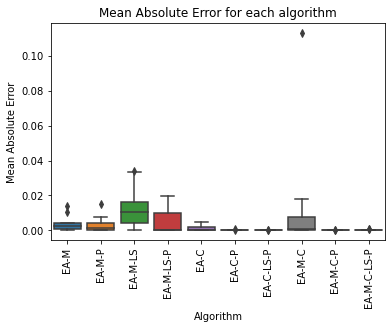

In [182]:
#BOX-PLOT MEAN AVERAGE ERROR

dataframe_mae = pd.DataFrame(all_mae[0], columns=[test_names[0]]) 


for i in range(1, len(test_names)):
    data = np.random.normal(size=100)
    dataframe_mae.insert(i, test_names[i], all_mae[i], True)

ax = sns.boxplot(data=dataframe_mae);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error for each algorithm")
ax.set_xticklabels(test_names, rotation=90)
plt.show()

[[23, 63, 41, 27, 31, 63, 63, 63, 63, 63], [23, 23, 33, 63, 67, 67, 73, 23, 25, 35], [63, 63, 69, 59, 31, 17, 31, 21, 63, 15], [41, 25, 35, 67, 59, 27, 17, 63, 55, 67], [85, 329, 63, 279, 329, 209, 35, 237, 63, 205], [517, 151, 361, 243, 253, 145, 249, 561, 517, 503], [133, 239, 313, 179, 191, 223, 199, 231, 171, 307], [67, 273, 57, 67, 107, 129, 63, 75, 37, 75], [123, 243, 285, 137, 115, 1559, 141, 169, 489, 131], [165, 67, 125, 135, 211, 85, 157, 319, 97, 147]]


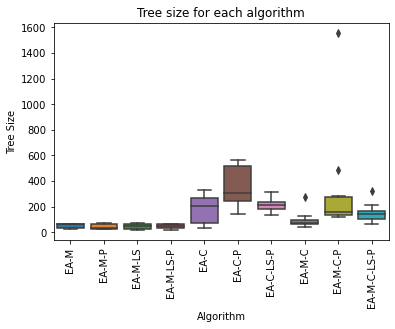

In [183]:
#BOX-PLOT TREE SIZE

print(all_tree_size)
dataframe_tree_size = pd.DataFrame(all_tree_size[0], columns=[test_names[0]]) 

for i in range(1, len(test_names)):
    data = np.random.normal(size=100)
    dataframe_tree_size.insert(i, test_names[i], all_tree_size[i], True)

ax = sns.boxplot(data=dataframe_tree_size);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Tree Size")
ax.set_title("Tree size for each algorithm")
ax.set_xticklabels(test_names, rotation=90)
plt.show()

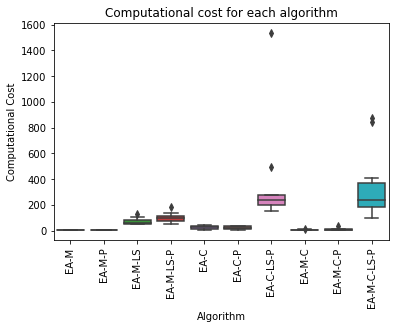

In [184]:
#BOX-PLOT COMPUTATIONAL COST

dataframe_comp_cost = pd.DataFrame(all_comp_cost[0], columns=[test_names[0]]) 

for i in range(1, len(test_names)):
    data = np.random.normal(size=100)
    dataframe_comp_cost.insert(i, test_names[i], all_comp_cost[i], True)

ax = sns.boxplot(data=dataframe_comp_cost);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Computational Cost")
ax.set_title("Computational cost for each algorithm")
ax.set_xticklabels(test_names, rotation=90)
plt.show()

In [69]:
#P-VALUE (PAIRED T-TEST)

def sig_round(x, sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [73]:
test_statistics_tree_size = []

for i in range(len(test_names)):
    row = []
    for j in range(len(test_names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_tree_size[i], all_tree_size[j])[1])
    
    test_statistics_tree_size.append(row)

test_statistics_tree_size_df = pd.DataFrame(test_statistics_tree_size)
test_statistics_tree_size_df.to_csv('Tree-Size-pvalue.csv')
test_statistics_tree_size_df

,0,1,2,3,4,5,6,7,8,9
0,nil,0.445964,0.453136,0.594191,0.00175388,1.63669e-05,5.24555e-08,0.0565685,0.0542163,0.000456044
1,0.445964,nil,1,0.793556,0.0012167,1.29291e-05,4.01532e-08,0.0330689,0.0494052,0.000277387
2,0.453136,1,nil,0.796559,0.0012264,1.30027e-05,4.21825e-08,0.0334517,0.049418,0.000283423
3,0.594191,0.793556,0.796559,nil,0.00136304,1.38949e-05,4.00295e-08,0.0391614,0.0510315,0.000316683
4,0.00175388,0.0012167,0.0012264,0.00136304,nil,0.01591,0.393422,0.0487586,0.296306,0.454353
5,1.63669e-05,1.29291e-05,1.30027e-05,1.38949e-05,0.01591,nil,0.0265194,0.000226861,0.943165,0.0023029
6,5.24555e-08,4.01532e-08,4.21825e-08,4.00295e-08,0.393422,0.0265194,nil,0.000340459,0.405203,0.0323808
7,0.0565685,0.0330689,0.0334517,0.0391614,0.0487586,0.000226861,0.000340459,nil,0.102496,0.0920843
8,0.0542163,0.0494052,0.049418,0.0510315,0.296306,0.943165,0.405203,0.102496,nil,0.20172
9,0.000456044,0.000277387,0.000283423,0.000316683,0.454353,0.0023029,0.0323808,0.0920843,0.20172,nil


In [45]:
test_statistics_mae = []

for i in range(len(test_names)):
    row = []
    for j in range(len(test_names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_mae[i], all_mae[j])[1])
    
    test_statistics_mae.append(row)

test_statistics_mae_df = pd.DataFrame(test_statistics_mae)
test_statistics_mae_df.to_csv('mae-pvalue.csv')
test_statistics_mae_df

,0,1,2,3,4,5,6,7,8,9
0,nil,0.74536,0.0447145,0.763025,0.0922895,0.0154287,0.0140329,0.364182,0.0149198,0.0190125
1,0.74536,nil,0.0327107,0.585764,0.214248,0.048663,0.0447449,0.334032,0.0472462,0.0583572
2,0.0447145,0.0327107,nil,0.0888595,0.00782221,0.0038577,0.00371942,0.903723,0.00380857,0.00417415
3,0.763025,0.585764,0.0888595,nil,0.143877,0.0536725,0.0508277,0.408895,0.052657,0.0603229
4,0.0922895,0.214248,0.00782221,0.143877,nil,0.0562259,0.0442712,0.249894,0.0516328,0.0949065
5,0.0154287,0.048663,0.0038577,0.0536725,0.0562259,nil,0.22183,0.212343,0.720424,0.345318
6,0.0140329,0.0447449,0.00371942,0.0508277,0.0442712,0.22183,nil,0.210415,0.255431,0.142842
7,0.364182,0.334032,0.903723,0.408895,0.249894,0.212343,0.210415,nil,0.211669,0.216462
8,0.0149198,0.0472462,0.00380857,0.052657,0.0516328,0.720424,0.255431,0.211669,nil,0.257436
9,0.0190125,0.0583572,0.00417415,0.0603229,0.0949065,0.345318,0.142842,0.216462,0.257436,nil


In [46]:
test_statistics_comp_time = []

for i in range(len(test_names)):
    row = []
    for j in range(len(test_names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_comp_cost[i], all_comp_cost[j])[1])
    
    test_statistics_comp_time.append(row)

test_statistics_comp_time_df = pd.DataFrame(test_statistics_comp_time)
test_statistics_comp_time_df.to_csv('comp-time-pvalue.csv')
test_statistics_comp_time_df

,0,1,2,3,4,5,6,7,8,9
0,nil,0.334943,2.94877e-07,7.06867e-07,0.000359676,0.00141807,0.0107667,0.0183106,0.0233588,0.000982112
1,0.334943,nil,2.60346e-07,6.49156e-07,0.000265592,0.0010432,0.0106688,0.00446054,0.0147845,0.000968273
2,2.94877e-07,2.60346e-07,nil,0.103971,8.35992e-05,4.22176e-05,0.0322115,5.67637e-07,2.37801e-06,0.0056734
3,7.06867e-07,6.49156e-07,0.103971,nil,2.68416e-05,1.67269e-05,0.0485182,1.09821e-06,2.61658e-06,0.0112202
4,0.000359676,0.000265592,8.35992e-05,2.68416e-05,nil,0.638962,0.0147837,0.0017115,0.0267346,0.00161979
5,0.00141807,0.0010432,4.22176e-05,1.67269e-05,0.638962,nil,0.014097,0.00666775,0.0791167,0.00150312
6,0.0107667,0.0106688,0.0322115,0.0485182,0.0147837,0.014097,nil,0.0112693,0.0120562,0.856722
7,0.0183106,0.00446054,5.67637e-07,1.09821e-06,0.0017115,0.00666775,0.0112693,nil,0.17709,0.00105447
8,0.0233588,0.0147845,2.37801e-06,2.61658e-06,0.0267346,0.0791167,0.0120562,0.17709,nil,0.00117347
9,0.000982112,0.000968273,0.0056734,0.0112202,0.00161979,0.00150312,0.856722,0.00105447,0.00117347,nil


In [ ]:



#CAN STOP READING CODE PAST THIS POINT. SEPERATE IMPLEMENTATIONS OF INITAL TESTING. 
#CONGREGATED ALL TESTS ABOVE TO ONE FUNCTION FOR SIMPLICITY SAKE




In [298]:
#GENETIC ALGORITHM ONLY CROSSOVER

#order = ["algorithm-1", "algorithm-2", "algorithm-3", "algorithm-4"]

all_mae = []
all_comp_cost = []
all_tree_size = []

In [299]:
def only_crossover():
    
    #intialise population
    pop = initalise_population()
    data = dataset()
    fitnesses = calculate_fitness(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 50):
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            #crossover
            parent1.crossover(parent2)

            #mutation
            parent1.mutation()

            #add child to population
            new_pop.append(parent1)

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation

            #print("-----------BEST RUN FOUND-----------")
            #print("GENERATION: ", generation)
            #print("FITNESS: ", best_run_fitness)
            #print("--------------THE TREE--------------")
            #inorder(best_run_tree)


        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        fitnesses = calculate_fitness(pop, data)
        
    return best_run_tree



In [300]:
print("GENETIC ALGORITHM ONLY CROSSOVER")
#TESTING 
bestRunsTree = []
bestRunsTime = []

for i in range(10):
    start = timer()
    bestRunsTree.append(only_crossover())
    end = timer()
    bestRunsTime.append(end - start)

treeSizes = []
mae = []

data = dataset()

for i in range(len(bestRunsTree)):
    treeSizes.append(bestRunsTree[i].size())
    mae.append(individual_fitness(bestRunsTree[i], data))

all_mae.insert(len(all_mae), mae)
all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9


In [301]:

#GRAPHING


In [302]:
#Mean absolute error of best solution with crossover and no parsimony pressure

#x is generations
#y is node size
xAxis = []
for i in range(len(bestRunsTree)):
    xAxis.append(i + 1)

data = {'Test Instance': xAxis,
        'Fitness (Mean Absolute Error)': mae}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Fitness (Mean Absolute Error)",
             title="Mean absolute error of best solution with crossover and no parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(mae) / len(mae)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)

fig.write_image("with_crossover-mae.pdf")
#fig.show()

In [303]:
#Tree size of best solution with crossover and no parsimony pressure
data = {'Test Instance': xAxis,
        'Tree size (Amount of nodes)': treeSizes}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Tree size (Amount of nodes)",
             title="Tree size of best solution with crossover and no parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(treeSizes) / len(treeSizes)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover-treesize.pdf')
#fig.show()

In [304]:
#Time to run each test instance with crossover and no parsimony pressure
data = {'Test Instance': xAxis,
        'Time (Seconds)': bestRunsTime}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Time (Seconds)",
             title="Time to run each test instance with crossover and no parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(bestRunsTime) / len(bestRunsTime)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover-time.pdf')
#fig.show()

In [307]:


#GENETIC ALGORITHM WITH CROSSOVER (WITH PARSIMONY PRESSURE)



In [308]:

def with_crossover_parsimony_pressure():
    #intialise population
    pop = initalise_population()
    data = dataset()
    fitnesses = calculate_fitness_parsimony(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 100):
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            #crossover 
            parent1.crossover(parent2)

            #mutation
            parent1.mutation()

            #add child to population
            new_pop.append(parent1)

        #----------End Generation------------#

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation

            #print("-----------BEST RUN FOUND-----------")
            #print("GENERATION: ", generation)
            #print("FITNESS: ", best_run_fitness)
            #print("--------------THE TREE--------------")
            #inorder(best_run_tree)


        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        fitnesses = calculate_fitness_parsimony(pop, data)
    return best_run_tree

In [309]:
#TESTING 

bestRunsTree = []
bestRunsTime = []

for i in range(10):
    start = timer()
    bestRunsTree.append(with_crossover_parsimony_pressure())
    end = timer()
    bestRunsTime.append(end - start)

treeSizes = []
mae = []

data = dataset()

for i in range(len(bestRunsTree)):
    treeSizes.append(bestRunsTree[i].size())
    mae.append(individual_fitness(bestRunsTree[i], data))

all_mae.insert(len(all_mae), mae)
all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9


In [310]:

#GRAPHING


In [311]:
#Mean absolute error of best solution with crossover and parsimony pressure

xAxis = []
for i in range(len(bestRunsTree)):
    xAxis.append(i+1)

data = {'Test Instance': xAxis,
        'Fitness (Mean Absolute Error)': mae}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Fitness (Mean Absolute Error)",
             title="Mean absolute error of best solution with crossover and parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(mae) / len(mae)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover_parsimonypressure-mae.pdf')
#fig.show()

In [312]:
#Tree size of best solution with crossover and parsimony pressure

data = {'Test Instance': xAxis,
        'Tree size (Amount of nodes)': treeSizes}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Tree size (Amount of nodes)",
             title="Tree size of best solution with crossover and parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(treeSizes) / len(treeSizes)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover_parsimonypressure-treesize.pdf')
#fig.show()

In [313]:
#Time to run each test instance with crossover and parsimony pressure

data = {'Test Instance': xAxis,
        'Time (Seconds)': bestRunsTime}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Time (Seconds)",
             title="Time to run each test instance with crossover and parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(bestRunsTime) / len(bestRunsTime)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover_parsimonypressure-time.pdf')
#fig.show()

In [316]:



#GENETIC ALGORITHM WITHOUT CROSSOVER




In [317]:
def without_crossover():
    #intialise population
    pop = initalise_population()
    data = dataset()
    fitnesses = calculate_fitness(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 50):
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            if(individual_fitness(parent1, data) < individual_fitness(parent2, data)):
                #mutation
                parent1.mutation()
                #add child to population
                new_pop.append(parent1)
            else:
                #mutation
                parent2.mutation()
                #add child to population
                new_pop.append(parent2)

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation

            #print("-----------BEST RUN FOUND-----------")
            #print("GENERATION: ", generation)
            #print("FITNESS: ", best_run_fitness)
            #print("--------------THE TREE--------------")
            #inorder(best_run_tree)


        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        fitnesses = calculate_fitness(pop, data)
    return best_run_tree

In [318]:
#TESTING
print("GENETIC ALGORITHM WITHOUT CROSSOVER")

bestRunsTree = []
bestRunsTime = []

for i in range(10):
    start = timer()
    bestRunsTree.append(without_crossover())
    end = timer()
    bestRunsTime.append(end - start)

treeSizes = []
mae = []

data = dataset()

for i in range(len(bestRunsTree)):
    treeSizes.append(bestRunsTree[i].size())
    mae.append(individual_fitness(bestRunsTree[i], data))

all_mae.insert(len(all_mae), mae)
all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9


In [319]:

#GRAPHING


In [320]:
#Mean absolute error of best solution without crossover

xAxis = []
for i in range(len(bestRunsTree)):
    xAxis.append(i + 1)

data = {'Test Instance': xAxis,
        'Fitness (Mean Absolute Error)': mae}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Fitness (Mean Absolute Error)",
             title="Mean absolute error of best solution without crossover")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(mae) / len(mae)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('without_crossover-mae.pdf')

#fig.show()

In [321]:
#Tree size of best solution without crossover

data = {'Test Instance': xAxis,
        'Tree size (Amount of nodes)': treeSizes}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Tree size (Amount of nodes)",
             title="Tree size of best solution without crossover")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(treeSizes) / len(treeSizes)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('without_crossover-treesize.pdf')
#fig.show()

In [322]:
#Time to run each test instance without crossover

data = {'Test Instance': xAxis,
        'Time (Seconds)': bestRunsTime}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Time (Seconds)",
             title="Time to run each test instance without crossover")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(bestRunsTime) / len(bestRunsTime)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('without_crossover-time.pdf')
#fig.show()

In [325]:
#GENETIC ALGORITHM WITH CROSSOVER AND PARSIMONY PRESSURE AND LOCAL SEARCH

In [326]:
def with_crossover_parsimonyPressure_localSearch():
    #intialise population
    pop = initalise_population()
    data = dataset()
    fitnesses = calculate_fitness(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 50):
        print(generation)
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            #crossover
            parent1.crossover(parent2)

            #local search
            parent1.local_search_one(parent1, data)

            #mutation
            parent1.mutation()

            #add child to population
            new_pop.append(parent1)

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation



        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        fitnesses = calculate_fitness(pop, data)
    return best_run_tree


In [327]:
#TESTING 

bestRunsTree = []
bestRunsTime = []

for i in range(10):
    start = timer()
    bestRunsTree.append(with_crossover_parsimonyPressure_localSearch())
    end = timer()
    bestRunsTime.append(end - start)

treeSizes = []
mae = []

data = dataset()

for i in range(len(bestRunsTree)):
    treeSizes.append(bestRunsTree[i].size())
    mae.append(individual_fitness(bestRunsTree[i], data))

all_mae.insert(len(all_mae), mae)
all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9


In [328]:
#GRAPHING

In [329]:
#Mean absolute error of best solution with crossover and parsimony pressure and local search

xAxis = []
for i in range(len(bestRunsTree)):
    xAxis.append(i+1)

data = {'Test Instance': xAxis,
        'Fitness (Mean Absolute Error)': mae}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Fitness (Mean Absolute Error)",
             title="Mean absolute error of best solution with crossover and parsimony pressure and local search")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(mae) / len(mae)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('crossover_parsimonypressure_localsearch-mae.pdf')
fig.show()

In [330]:
#Tree size of best solution with crossover and parsimony pressure and local search

data = {'Test Instance': xAxis,
        'Tree size (Amount of nodes)': treeSizes}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Tree size (Amount of nodes)",
             title="Tree size of best solution with crossover and parsimony pressure and local search")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(treeSizes) / len(treeSizes)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('crossover_parsimonypressure_localsearch-treesize.pdf')
fig.show()

In [331]:
#Time to run each test instance with crossover and parsimony pressure and local search

print(xAxis)
print(bestRunsTime)
data = {'Test Instance': xAxis,
        'Time (Seconds)': bestRunsTime}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Time (Seconds)",
             title="Time to run each test instance with crossover and parsimony pressure and local search")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(bestRunsTime) / len(bestRunsTime)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('crossover_parsimonypressure_localsearch-time.pdf')
fig.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[151.64266981900437, 359.9622105549788, 120.09828884899616, 118.04201597900828, 202.49566127196886, 122.6480545939994, 119.55793894699309, 337.9989775180002, 97.60493448097259, 68.02498061698861]


In [340]:
#OUTPUTTING BOX PLOTS
#names = ["without-crossover", "with_crossover_parsimonypressure", "with_crossover", "crossover_parsimonypressure_localsearch"]
names = ["EA-M", "EA-M-C", "EA-M-C-P", "EA-M-C-P-LS"]

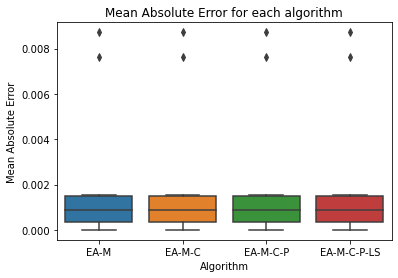

In [341]:
#BOX-PLOT MEAN AVERAGE ERROR

dataframe_mae = pd.DataFrame(all_mae[0], columns=[names[0]]) 


for i in range(1, len(names)):
    data = np.random.normal(size=100)
    dataframe_mae.insert(i, names[i], all_mae[0], True)


ax = sns.boxplot(data=dataframe_mae);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error for each algorithm")
plt.show()

[[31, 63, 219, 309, 31, 95, 99, 121, 31, 61], [271, 255, 799, 653, 301, 219, 449, 1255, 137, 981], [63, 63, 31, 31, 63, 63, 63, 63, 63, 63], [67, 97, 55, 63, 43, 63, 25, 117, 27, 41]]


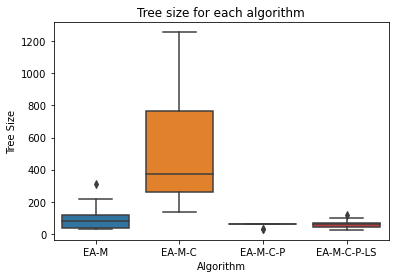

In [342]:
#BOX-PLOT TREE SIZE

dataframe_tree_size = pd.DataFrame(all_tree_size[0], columns=[names[0]]) 

for i in range(1, len(names)):
    data = np.random.normal(size=100)
    dataframe_tree_size.insert(i, names[i], all_tree_size[i], True)

ax = sns.boxplot(data=dataframe_tree_size);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Tree Size")
ax.set_title("Tree size for each algorithm")
plt.show()

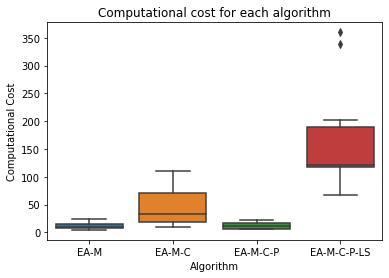

In [343]:
#BOX-PLOT COMPUTATIONAL COST

dataframe_comp_cost = pd.DataFrame(all_comp_cost[0], columns=[names[0]]) 

for i in range(1, len(names)):
    data = np.random.normal(size=100)
    dataframe_comp_cost.insert(i, names[i], all_comp_cost[i], True)

ax = sns.boxplot(data=dataframe_comp_cost);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Computational Cost")
ax.set_title("Computational cost for each algorithm")
plt.show()

In [348]:
#TEST STATISTICS

#DATA COLLECTED IN ARRAYS: all_mae, all_comp_cost, all_tree_size
#Indexs are each algorithm. E.g index 0 is algorithm 0, index 1 is algorithm 1, ......

In [361]:
test_statistics_tree_size = []

for i in range(len(names)):
    row = []
    for j in range(len(names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_tree_size[i], all_tree_size[j])[1])
    
    test_statistics_tree_size.append(row)

test_statistics_tree_size_df = pd.DataFrame(test_statistics_tree_size)
test_statistics_tree_size_df.to_csv('Tree-Size-pvalue.csv')
test_statistics_tree_size_df

,0,1,2,3
0,nil,0.00264087,0.107976,0.145082
1,0.00264087,nil,0.000838986,0.0009097
2,0.107976,0.000838986,nil,0.756688
3,0.145082,0.0009097,0.756688,nil


In [354]:
test_statistics_mae = []

for i in range(len(names)):
    row = []
    for j in range(len(names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_mae[i], all_mae[j])[1])
    
    test_statistics_mae.append(row)

test_statistics_mae_df = pd.DataFrame(test_statistics_mae)
test_statistics_mae_df.to_csv('mae-pvalue.csv')
test_statistics_mae_df

,0,1,2,3
0,nil,0.043849,0.235359,0.137988
1,0.043849,nil,0.0307089,0.00258183
2,0.235359,0.0307089,nil,0.90689
3,0.137988,0.00258183,0.90689,nil


In [355]:
test_statistics_comp_time = []

for i in range(len(names)):
    row = []
    for j in range(len(names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_comp_cost[i], all_comp_cost[j])[1])
    
    test_statistics_comp_time.append(row)

test_statistics_comp_time_df = pd.DataFrame(test_statistics_comp_time)
test_statistics_comp_time_df.to_csv('comp-time-pvalue.csv')
test_statistics_comp_time_df

,0,1,2,3
0,nil,0.0064903,0.646182,9.86459e-05
1,0.0064903,nil,0.0082296,0.00218416
2,0.646182,0.0082296,nil,0.000107646
3,9.86459e-05,0.00218416,0.000107646,nil
